In [1]:
# Libraries

# For API requests
import requests
import io

# For managing json files
import json

# For processing data
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import date
from datetime import timedelta
import matplotlib.dates as mdates

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.formula.api as smf


from scipy.signal import savgol_filter # Media Movil


In [ ]:
# CLIMA

url = "https://www.ncei.noaa.gov/data/daily-summaries/access/USW00094728.csv"
urlData = requests.get(url).content
rawData = pd.read_csv(io.StringIO(urlData.decode('utf-8')), dtype={"PRCP": "int32", 'SNOW':'float'}, parse_dates=['DATE'])
clima = rawData[['DATE','PRCP','SNOW']]
clima.columns = ['date', 'prcp', 'snow']

In [3]:
# CRASHES

url = 'https://data.cityofnewyork.us/resource/h9gi-nx95.json?' 
token = 'c7nn42f3kh67innzws0qb33hd' # personal token

def GetData(url,token):
    hed = {'X-Auth-Token': f'{token}'}
    url = url + '$limit=2000000' # Adding limit 2.000.000 to get all the data
    response = requests.get(url, headers=hed)
    response_jason = json.loads(response.text)
    df = pd.json_normalize(response_jason)
    return df

df = GetData(url,token)

In [5]:
# PREPROCESSING

# LIMPIEZA NANS y CAMBIO TIPO DE COLUMNAS

df.drop(df[df.collision_id.isnull()].index,inplace=True) #BORRAR VALORES NULOS PARA PODER REALIZAR LA ASIGNACION DE INDICE
df['collision_id'] = df['collision_id'].astype(int)
df=df.set_index('collision_id')

df.drop(df[df.number_of_persons_killed.isna()==True].index, inplace=True)
df.drop(df[df.number_of_persons_injured.isna()==True].index, inplace=True)
df.drop(df[df.number_of_pedestrians_injured.isna()==True].index, inplace=True)
df.drop(df[df.number_of_pedestrians_killed.isna()==True].index, inplace=True)
df.drop(df[df.number_of_motorist_injured.isna()==True].index, inplace=True)
df.drop(df[df.number_of_motorist_killed.isna()==True].index, inplace=True)
df.drop(df[df.number_of_cyclist_injured.isna()==True].index, inplace=True)
df.drop(df[df.number_of_cyclist_killed.isna()==True].index, inplace=True)

# CAMBIO TIPO

df = df.astype({
 'crash_date': 'datetime64', 
 'number_of_cyclist_injured': 'int8', 
 'number_of_cyclist_killed': 'int8',
 'number_of_motorist_injured': 'int8',
 'number_of_motorist_killed': 'int8',
 'number_of_pedestrians_injured': 'int8',
 'number_of_pedestrians_killed': 'int8',
 'number_of_persons_injured': 'int8',
 'number_of_persons_killed': 'int8',
})

# NORMALIZACION CALLES

def norm_calles(x):
    x.loc[x.str.contains('avenue|boulevard|av|blvd|bvld|blbd|blv|terrance|bl|luther', case=False)] = 'AVENUE'
    x.loc[x.str.contains('tunnel|under|viaduct', case=False)] = 'TUNNEL'
    x.loc[x.str.contains('bridge|ridge|BDIRGE|lower|upper|level', case=False)] = 'BRIDGE'    
    x.loc[x.str.contains('road|rd|rod', case=False)] = 'ROAD'
    x.loc[x.str.contains('way', case=False)] = 'HIGHWAY'
    x.loc[x.str.contains('pkwy|expy|pike|ramp|pwky|expwy|exit|exwy|exp|entrance|i-|hwy|i95|i 95|-51|E 59|-28|-45|i2|tpk', case=False)] = 'HIGHWAY'
    x.loc[x.str.contains('street|str|st|heights|course|alley|cross|walk|crescent|path|sreet|boy|slip|lane|drive|dr|line|hill|trail|court|loop|circle|place|park|plaza|pl|ln|terrace|square|sq|terr|bowery', case=False)] = 'STREET'
    x.loc[~x.str.contains('AVENUE|TUNNEL|BRIDGE|STREET|ROAD|HIGHWAY|UNKNOWN')] = 'UNKNOWN'
    return x

df['on_street_name_c'] = norm_calles(df['on_street_name'].fillna('UNKNOWN'))

# DROPEO COLUMNAS QUE NO SIRVEN

df.drop(columns=['on_street_name',
                 'vehicle_type_code1', 
                 'vehicle_type_code2',
                 'vehicle_type_code_3',
                 'vehicle_type_code_4',
                 'vehicle_type_code_5',
                 'off_street_name',
                 'cross_street_name',
                 'contributing_factor_vehicle_3',
                 'contributing_factor_vehicle_4',
                 'contributing_factor_vehicle_5',
                 'location.latitude',
                 'location.longitude',
                 'location.human_address'
                ], 
        inplace=True)

# AGREGO SEASON

def MonthToSeason(x):   
    global season
    if x == 3 or x == 4 or x == 5:
         season = "spring"
    elif x == 6 or x == 7 or x == 8:
         season = "summer"
    elif x == 9 or x == 10 or x == 11:
         season = "autumn"
    elif x == 12 or x == 1 or x == 2:
         season = "winter"
    else:
         season = np.nan 
    return season

df['season']= pd.to_datetime(df['crash_date']).dt.month.apply(lambda x : MonthToSeason(x))

In [39]:
# GENERACION DEL DF FINAL PARA TRABAJAR

# Agrupo las variables
df_reglin = df.groupby(['crash_date']).agg({'crash_date': ['count']}).reset_index()


# Dropeo un nivel del multi-index
df_reglin = df_reglin.droplevel(level=1, axis=1)

# Renombro las columnas
df_reglin.columns = ['crash_date','number_of_crashes']

# Converting date to numerical so we can make an input of it for our model
df_reglin['crash_date_ord'] = df_reglin['crash_date'].apply(lambda x: x.toordinal())

df_reglin.head()

,crash_date,number_of_crashes,crash_date_ord
0,2012-07-01,538,734685
1,2012-07-02,564,734686
2,2012-07-03,664,734687
3,2012-07-04,432,734688
4,2012-07-05,591,734689


In [188]:
# Limito el periodo de analisis
df_reglin = df_reglin[df_reglin['crash_date'] > '2020-1-1']

# Feature and response
X = df_reglin['crash_date_ord']
y = df_reglin['number_of_crashes']

In [42]:
df_reglin.corr()

,number_of_crashes,crash_date_ord
number_of_crashes,1.00000,-0.54651
crash_date_ord,-0.54651,1.00000


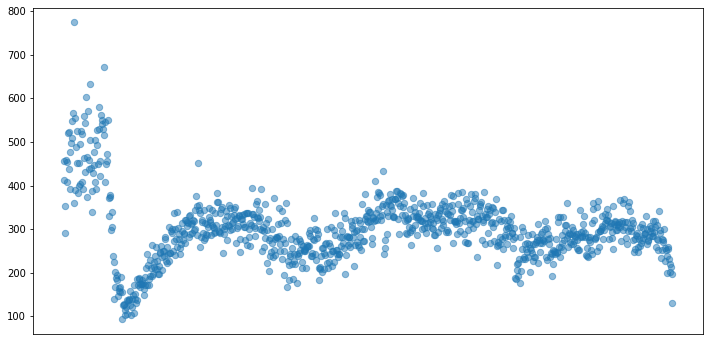

In [189]:
plt.figure(figsize=(12,6))
plt.scatter(X, y, alpha=0.5, s=40)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

In [190]:
# Lineal Correlation between the 2 variables (Fecha and Value)
# ==============================================================================
corr_test = pearsonr(x = X, y =  y)
print("Coeficiente de correlación de Pearson: ", corr_test[0])
print("P-value: ", corr_test[1])

Coeficiente de correlación de Pearson:  -0.1446242799418204
P-value:  5.788929917472969e-06


In [191]:
# Fitting the model
# ===============================================================================
X_scaled = X.values.reshape(-1,1)
y_scaled = y.values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size = 0.2, random_state=123)

lr = LinearRegression()

modelo = lr.fit(X_train, y_train)

In [192]:
# Información del modelo
# ==============================================================================
print("Intercept:", lr.intercept_)
print("Coeficiente:", lr.coef_)
print("Coeficiente de determinación R^2:", lr.score(X_scaled, y_scaled))
print('--------------------')
print('The linear model gets the equation:')
print(f'dolar blue = {lr.intercept_} + {lr.coef_} * fecha')
print('--------------------')
print(f'The R-squared value indicates that the model is capable of explaining {round(lr.score(X_scaled, y_scaled),3)*100}% of the variability observed in the response variable.')

Intercept: [28221.16158915]
Coeficiente: [[-0.03783793]]
Coeficiente de determinación R^2: 0.020842407656022077
--------------------
The linear model gets the equation:
dolar blue = [28221.16158915] + [[-0.03783793]] * fecha
--------------------
The R-squared value indicates that the model is capable of explaining 2.1% of the variability observed in the response variable.


In [193]:
# Predicting
# ==============================================================================
y_test_predict = lr.predict(X_test)
y_train_predict = lr.predict(X_train)

# MSE evaluation
# ==============================================================================
rmse_train = mean_squared_error(y_true  = y_train, y_pred  = y_train_predict, squared=False)
rmse_test = mean_squared_error(y_true  = y_test, y_pred  = y_test_predict, squared=False)
print(f"The predictions in the TRAIN set of the final model are on average {rmse_train} units away from the real value.")
print(f"The predictions in the TEST set of the final model are on average {rmse_test} units away from the real value.")

The predictions in the TRAIN set of the final model are on average 75.22004500684024 units away from the real value.
The predictions in the TEST set of the final model are on average 76.54593710920817 units away from the real value.


In [194]:
print('Precisión del modelo:')
print(lr.score(X_train, y_train))

Precisión del modelo:
0.019687609971044018


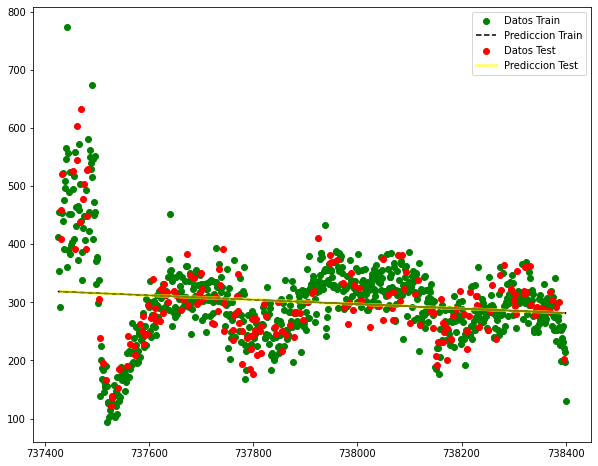

In [58]:
# Visualising the results

plt.figure(figsize = (10,8))

plt.scatter(X_train, y_train,  color='green', label = 'Datos Train')
plt.plot(X_train, y_train_predict, color='k', linestyle = '--', label = 'Prediccion Train')

plt.scatter(X_test, y_test,  color='red', label = 'Datos Test')
plt.plot(X_test, y_test_predict, color='yellow', linewidth=3.0, label = 'Prediccion Test',alpha=0.5)

plt.legend()
plt.show()

In [195]:
# CANTIDAD DE CHOQUES EN FECHA ESPECIFICA

fecha = '08/12/2022'
fecha2 = pd.to_datetime(fecha,format='%d/%m/%Y')
fecha2 = datetime.toordinal(fecha2)
fecha2 = np.array(fecha2)

prediction = lr.predict((fecha2.reshape(-1,1)))
print(f'El {fecha} habra un total de {round(prediction[0][0])} choques en NYC')

El 08/12/2022 habra un total de 278 choques en NYC


In [196]:
df_reglin[['crash_date','number_of_crashes']][df_reglin['crash_date'] == '2022-08-15']

,crash_date,number_of_crashes
2022-08-15,2022-08-15,233


In [197]:
# CANTIDAD DE CHOQUES ACUMULADOS

def crashesAcumulados():
    total_crashes = 0
    hoy = datetime.toordinal(pd.to_datetime(date.today().strftime("%d/%m/%Y"),format='%d/%m/%Y'))
    fecha_usuario = input('Ingrese una fecha')
    fecha_futuro = datetime.toordinal(pd.to_datetime(fecha_usuario,format='%d/%m/%Y'))

    for x in range(hoy,fecha_futuro+1):
        total_crashes += lr.predict((np.array(x).reshape(-1,1)))
    return print(f'Hasta el {fecha_usuario} habran {round(total_crashes[0][0])} choques en NYC')

crashesAcumulados()

Hasta el 15/09/2022 habran 2813 choques en NYC


## FORECAST


In [ ]:
import statsmodels.api as sm

<AxesSubplot:>

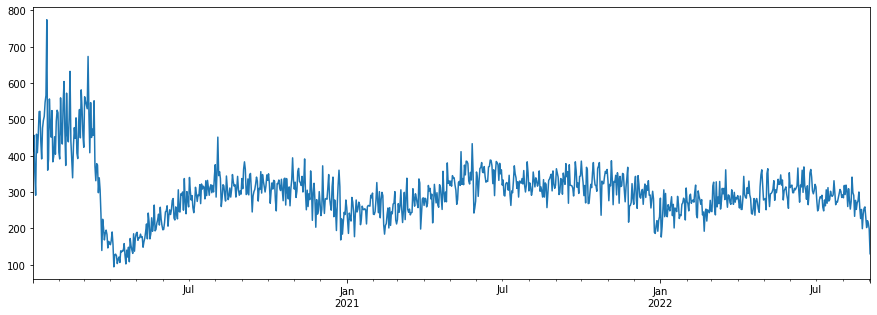

In [93]:
# Asigno una frecuencia como index
df_reglin.index = pd.period_range(start='2020-01-02', end='2022-09-02', freq='D')

endog = df_reglin['number_of_crashes']
#endog.plot(figsize=(15, 5))

In [94]:
# Construct the model
mod = sm.tsa.SARIMAX(endog, order=(1, 0, 0), trend='c')
# Estimate the parameters
res = mod.fit()

print(res.summary())

                               SARIMAX Results                                
Dep. Variable:      number_of_crashes   No. Observations:                  975
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -5095.360
Date:                Tue, 06 Sep 2022   AIC                          10196.720
Time:                        15:43:47   BIC                          10211.367
Sample:                    01-02-2020   HQIC                         10202.294
                         - 09-02-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     57.0478      4.204     13.570      0.000      48.808      65.287
ar.L1          0.8094      0.011     76.442      0.000       0.789       0.830
sigma2      2021.9011     49.944     40.483      0.0

In [114]:
res.get_forecast('2022-09-06').summary_frame()

number_of_crashes,mean,mean_se,mean_ci_lower,mean_ci_upper
2022-09-03,162.270865,44.965555,74.139997,250.401732
2022-09-04,188.391175,57.849231,75.008767,301.773584
2022-09-05,209.533175,64.918070,82.296096,336.770254
2022-09-06,226.645688,69.158533,91.097454,362.193922


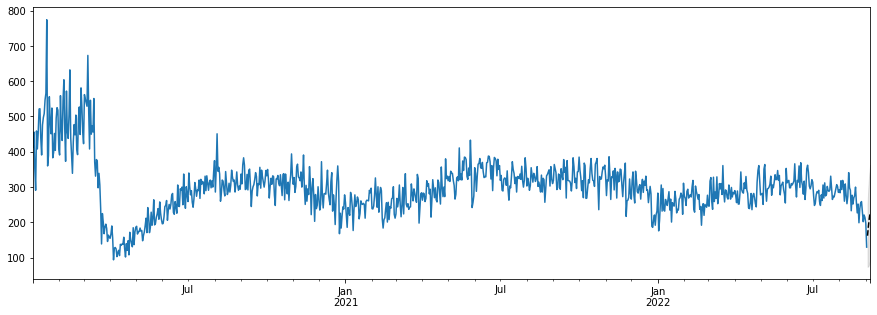

In [115]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
endog.loc['2020-01-01':].plot(ax=ax)

# Construct the forecasts
fcast = res.get_forecast('2022-09-06').summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);

# analisis extras


In [146]:
# GENERACION DEL DF FINAL PARA TRABAJAR

# Agrupo las variables
df_extra = df.groupby(['crash_date','borough']).agg({'crash_date': ['count']}).reset_index()


# Dropeo un nivel del multi-index
df_extra = df_extra.droplevel(level=1, axis=1)

# Renombro las columnas
df_extra.columns = ['crash_date','borough','number_of_crashes']

# Converting date to numerical so we can make an input of it for our model
#df_extra['crash_date_ord'] = df_extra['crash_date'].apply(lambda x: x.toordinal())

#df_extra = df_extra[df_extra['crash_date'] >= '2020-01-01'].reset_index(drop=True)

df_extra.head()

,crash_date,borough,number_of_crashes
0,2012-07-01,BRONX,39
1,2012-07-01,BROOKLYN,135
2,2012-07-01,MANHATTAN,119
3,2012-07-01,QUEENS,101
4,2012-07-01,STATEN ISLAND,26


In [147]:
# Transformacion columnas
df_extra['crash_date_ord'] = df_extra['crash_date'].map(datetime.toordinal)

le = preprocessing.LabelEncoder()
df_extra['borough_le'] = le.fit_transform(df_extra['borough'])
le.classes_
# BRONX = 0
# BROOKLYN = 1
# MANHATTAN = 2
# QUEENS = 3
# STATEN ISLAND = 4

array(['BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND'],
      dtype=object)

In [148]:
df_extra.head()

,crash_date,borough,number_of_crashes,crash_date_ord,borough_le
0,2012-07-01,BRONX,39,734685,0
1,2012-07-01,BROOKLYN,135,734685,1
2,2012-07-01,MANHATTAN,119,734685,2
3,2012-07-01,QUEENS,101,734685,3
4,2012-07-01,STATEN ISLAND,26,734685,4


<AxesSubplot:>

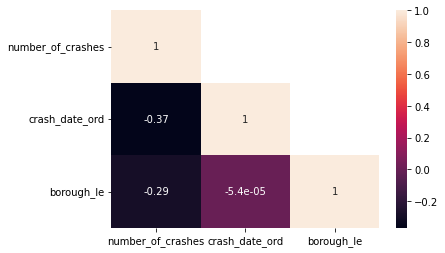

In [149]:
# CORRELACION
corr = df_extra.corr()
mask = np.triu(corr,1)
sns.heatmap(corr,annot=True,mask=mask)

In [158]:
# División de los datos en train y test
# ==============================================================================
X = df_extra[['crash_date_ord', 'borough_le']]
y = df_extra['number_of_crashes']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True,
                                        
                                    )

In [159]:
# Creación del modelo utilizando matrices como en scikitlearn
# ==============================================================================
# A la matriz de predictores se le tiene que añadir una columna de 1s para el intercept del modelo
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     2090.
Date:                Tue, 06 Sep 2022   Prob (F-statistic):               0.00
Time:                        16:34:35   Log-Likelihood:                -75684.
No. Observations:               14863   AIC:                         1.514e+05
Df Residuals:                   14860   BIC:                         1.514e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.134e+04    221.615     51.

In [173]:
# Error de test del modelo 
# ==============================================================================
X_test = sm.add_constant(X_test, prepend=True)
predicciones = modelo.predict(X_test)
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print("")
print(f"El error (rmse) de test es: {rmse}")


El error (rmse) de test es: 39.08071279026242


In [186]:
predicciones

3420     107.832529
8379      55.926099
2041     102.857519
7098      69.028746
4890     103.340940
            ...    
12845     79.034416
11550     82.991292
9332      71.391301
13996     57.137381
17947     35.876542
Length: 3716, dtype: float64

## Otra pueba con reg lineal multiple

In [180]:
# División de los datos en train y test
# ==============================================================================
X = df_extra[['crash_date_ord', 'borough_le']]
y = df_extra['number_of_crashes']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True,
                                        
                                    )

In [184]:
#Definimos el algoritmo a utilizar
lr_multiple = LinearRegression()
#Entrenamos el modelo
lr_multiple.fit(X_train, y_train)



In [187]:
# Error de test del modelo 
# ==============================================================================
prediccion = lr_multiple.predict(X_test)
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print("")
print(f"El error (rmse) de test es: {rmse}")


El error (rmse) de test es: 39.08071279026242


In [183]:
print('Precisión del modelo:')
print(lr_multiple.score(X_train, y_train))

Precisión del modelo:
0.21955551639452453
